# Demo Notebook
This notebook is to demonstrate the different classes and functions in the ipp_library.py file found in this repository. 

In [21]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain

In [22]:
import logging
reward_function = 'mean'
if not os.path.exists('./figures/' + str(reward_function)): 
    os.makedirs('./figures/' + str(reward_function))
logging.basicConfig(filename = './figures/'+ reward_function + '/robot.log', level = logging.INFO)
logger = logging.getLogger('robot')
from ipp_library import *

In [23]:
%matplotlib inline
%load_ext autoreload
%aimport ipp_library
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Current environment in violation of boundary constraint. Regenerating!
Environment initialized with bounds X1: ( 0.0 , 10.0 )  X2:( 0.0 , 10.0 )
World max value 26.21242571226806 at location [6.84210526 0.52631579]


TypeError: __init__() got an unexpected keyword argument 'computation_budget'

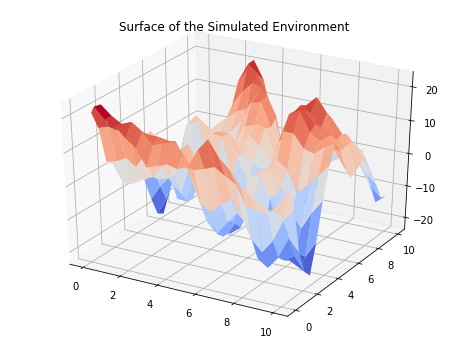

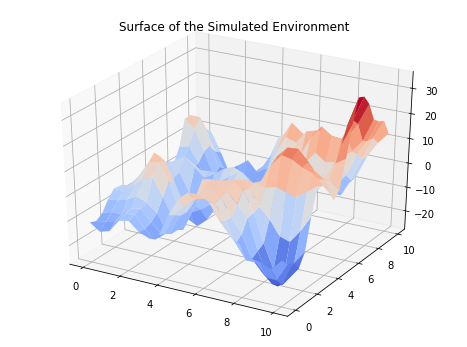

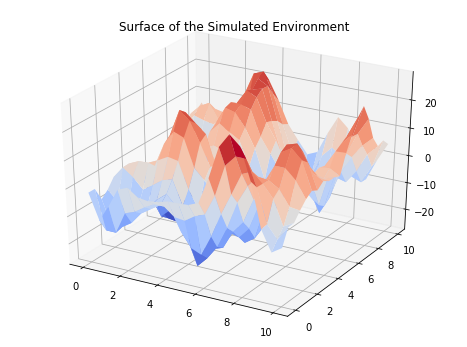

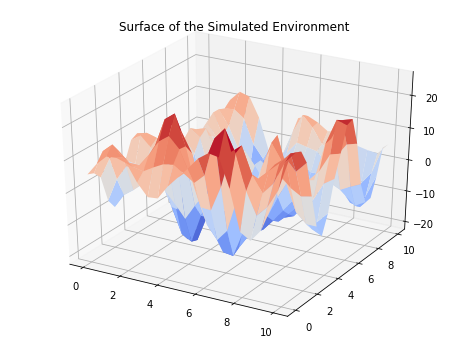

In [4]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 0)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
#x1observe = np.linspace(ranges[0]+0.5, ranges[1]-0,5, 15)
#x2observe = np.linspace(ranges[2]+0.5, ranges[3]-0.5, 15)
x1observe = np.linspace(0., 10., 20)
x2observe = np.linspace(0., 10., 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T

# TODO: make the edges less appealing!

observations = world.sample_value(data)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (9.85, 9.8225304782723271, 0.98947368421053028), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
#               prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 1.5, 
              turning_radius = 0.05,
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 100)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


Current environment in violation of boundary constraint. Regenerating!
Environment initialized with bounds X1: ( 0.0 , 10.0 )  X2:( 0.0 , 10.0 )
World max value 22.801464429649336 at location [1.57894737 9.47368421]
[ 0 ] Current Location:   (5.0, 5.0, 0.0)
Current predicted max and value: 	[[0. 0.]] 	0.0
[ 1 ] Current Location:   (3.945930384839669, 3.9327899708137335, -2.35)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[15.7791948]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[23.02549651]
Current predicted max and value: 	[5.51724138 5.51724138] 	7.407058026044431
[ 2 ] Current Location:   (2.918550005350788, 5.025717029606443, -3.957894736842105)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[18.7957538]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[29.72017746]
Current predicted max and value: 	[2.4137931  5.51724138] 	9.555658774095875
[ 3 ] Current Location:   (3.445084857092013, 6.430267153276597, -5

Max Value in Optimization 	 	[68.88879888]
Current predicted max and value: 	[1.72413793 9.31034483] 	23.261286589145268
[ 26 ] Current Location:   (8.586331657370039, 1.7335900165423783, -6.43157894736842)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[109.86951208]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[127.85688857]
Current predicted max and value: 	[1.72413793 9.31034483] 	23.26128315220054
[ 27 ] Current Location:   (9.112866509111262, 3.138140140212533, -5.071052631578946)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[66.02407994]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[168.02243269]
Current predicted max and value: 	[1.72413793 9.31034483] 	23.26128633929383
[ 28 ] Current Location:   (8.08548612962238, 4.231067199005242, -3.9578947368421042)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[117.24944576]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[10

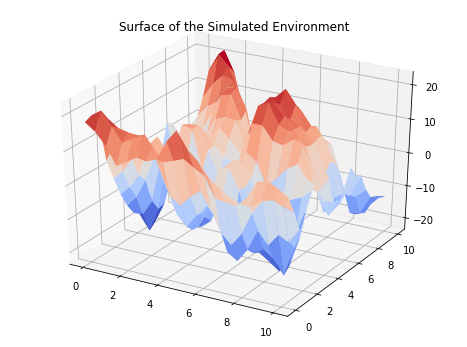

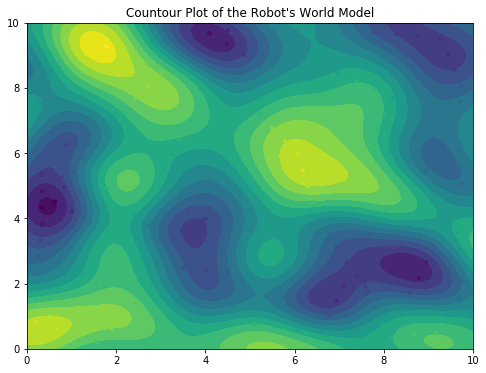

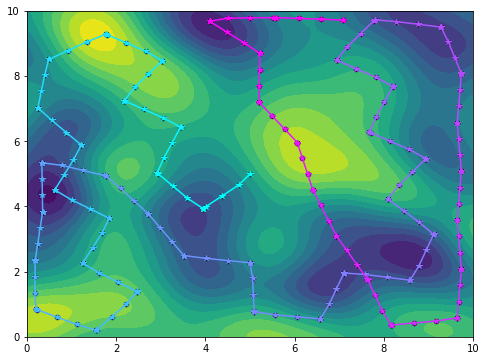

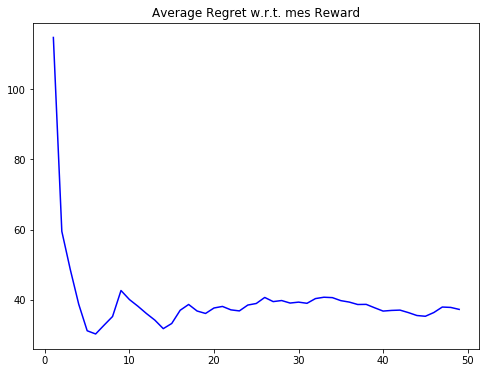

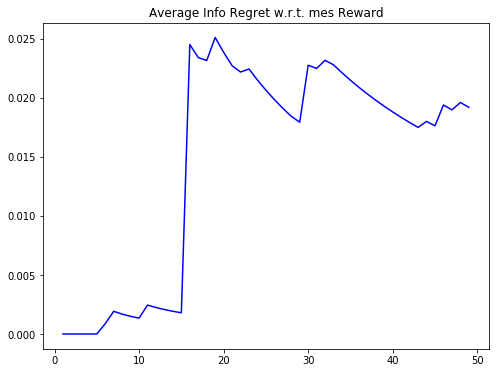

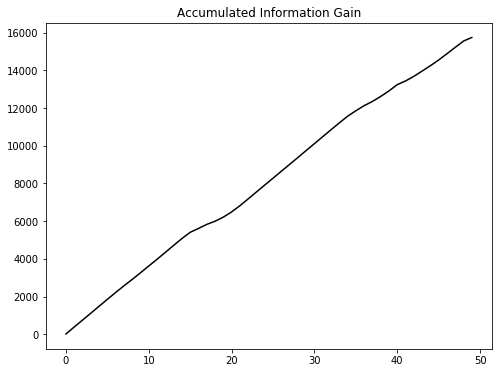

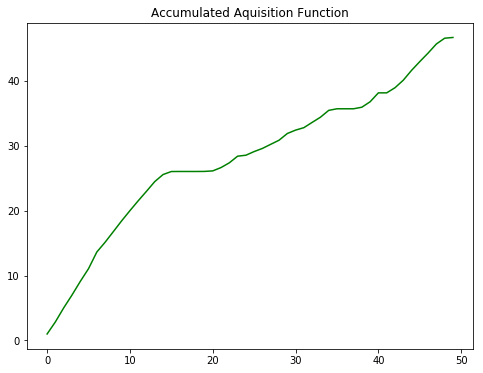

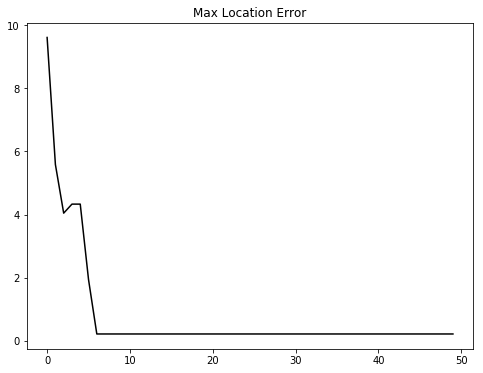

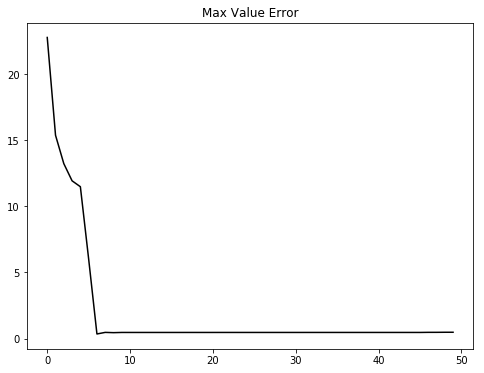

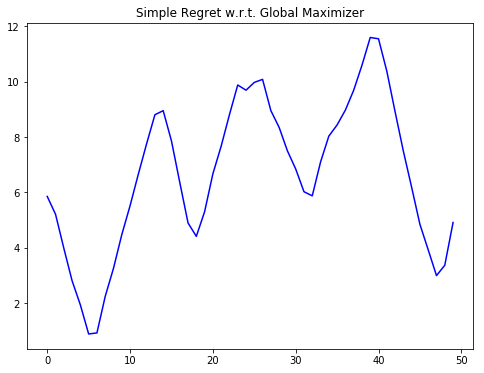

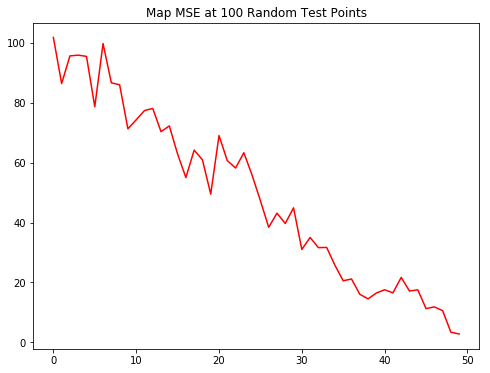

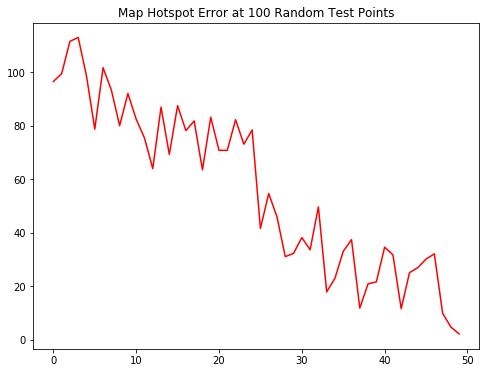

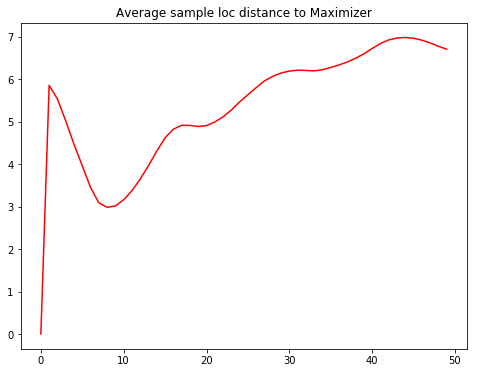

In [26]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, exp_improve and mes'''
reward_function = 'mes'
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 3)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(ranges[0], ranges[1], 8)
x2observe = np.linspace(ranges[2], ranges[3], 8)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Robot(sample_world = world.sample_value, 
              start_loc = (5.0, 5.0, 0.0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              #prior_dataset =  None, 
              prior_dataset =  None,#(data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 1.5, 
              turning_radius = 0.05, 
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True)

robot.planner(T = 50)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()

## [Link to trajectories and video](https://drive.google.com/drive/u/0/folders/1Xc5W2qg42H-HC5SGa_Gvvq0doq8sIaPp) for nonmyopic mes demo that gets stuck on the edge

In [ ]:
import io
import base64
from IPython.display import HTML


video = io.open('./figures/mes/output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
